1.) How to get softmask working in nvdiffrast
2.) Point light ?

In [1]:
!pip install -q matplotlib

import json
import os
import glob
import time

from PIL import Image
import torch
import numpy as np
from matplotlib import pyplot as plt

import kaolin as kal

from PIL import Image

import nvdiffrast
nvctx = nvdiffrast.torch.RasterizeGLContext(device='cuda')
import torchvision


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Warp 1.4.2 initialized:
   CUDA Toolkit 12.6, Driver 13.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 3050 Laptop GPU" (4 GiB, sm_86, mempool enabled)
   Kernel cache:
     /home/bhartrhari/.cache/warp/1.4.2


/home/bhartrhari/miniconda3/envs/kaolin_nv/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [2]:
# Hyperparameters
num_epoch = 50
batch_size = 2
laplacian_weight = 0.03
image_weight = 0.1
mask_weight = 1.
texture_lr = 5e-2
vertice_lr = 5e-4
scheduler_step_size = 20
scheduler_gamma = 0.5

texture_res = 400
width = 1824
height = 2736

source = torch.tensor([[0.,0.,1.]]).cuda()


In [3]:
pos = torch.tensor([-0.01,0.14,2]).reshape([1,3]) 
at = torch.tensor([-0.01,-0.03,0.0]).reshape([1,3])
up = torch.tensor([0., 1., 1.]).reshape([1,3])
fov = torch.tensor([0.2]) 

# pos = torch.tensor([-0.01,0.54,2]).reshape([1,3]) 
# at = torch.tensor([-0.01,-0.13,0.0]).reshape([1,3])
# up = torch.tensor([0., 1., 1.]).reshape([1,3])
# fov = torch.tensor([0.4]) 

at_light = torch.tensor([0.,0.,0.0]).reshape([1,3])
up_light = torch.tensor([0., 1., 1.]).reshape([1,3])
fov_light = torch.tensor([torch.pi])

camera = kal.render.camera.Camera.from_args(eye=pos, at=at, up = up, fov=fov, width = width, height = height,device = "cuda")

camera.requires_grad_(True)

with torch.no_grad():
    _, per_cam_to_ray_d = kal.render.camera.generate_pinhole_rays(camera)
    ray_d = -per_cam_to_ray_d.reshape(1,camera.height, camera.width, 3)

light = kal.render.camera.Camera.from_args(eye=source, at=at_light, up = up_light, fov=fov_light, width = width, height = height,device = "cuda")

with torch.no_grad():
    _, per_cam_to_ray_d = kal.render.camera.generate_pinhole_rays(light)
    light_ray = per_cam_to_ray_d.reshape(1,camera.height, camera.width, 3)

/home/bhartrhari/miniconda3/envs/kaolin_nv/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/bhartrhari/miniconda3/envs/kaolin_nv/lib/python3.11/site-packages/kaolin/render/camera/extrinsics_backends.py:225: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/aten/src/ATen/native/Cross.cpp:62.)
  b3 = torch.cross(b1, b2)


In [4]:
mesh = kal.io.gltf.import_mesh('./scan_mesh_working/scan_mesh_3_eye_lip_ear.glb').cuda()

/home/bhartrhari/miniconda3/envs/kaolin_nv/lib/python3.11/site-packages/kaolin/io/gltf.py:285: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/torch/csrc/utils/tensor_new.cpp:1560.)
  output = torch.frombuffer(
/home/bhartrhari/miniconda3/envs/kaolin_nv/lib/python3.11/site-packages/kaolin/io/gltf.py:324: UserWarning: gltf loader don't support vertex color yet. Please make a github request if needed.
  warnings.warn(


In [5]:
#mesh.vertices = kal.ops.pointcloud.center_points(mesh.vertices.unsqueeze(0), normalize=False).squeeze(0)


#help(mesh.materials[0])
print(mesh.materials[0].get_attributes())
materials = mesh.materials[0].diffuse_texture.unsqueeze(0)

print(materials.shape)
#materials = materials[0]
#materials = torch.ones(materials.shape).cuda()
mesh.uvs = torch.nn.functional.pad(mesh.uvs, (0, 0, 0, 1))
mesh.face_uvs_idx[mesh.face_uvs_idx == -1] = mesh.uvs.shape[1] - 1





['roughness_value', 'metallic_value', 'diffuse_texture', 'diffuse_colorspace', 'roughness_colorspace', 'metallic_colorspace', 'clearcoat_colorspace', 'clearcoat_roughness_colorspace', 'opacity_colorspace', 'ior_colorspace', 'specular_colorspace', 'normals_colorspace', 'displacement_colorspace', 'transmittance_colorspace', 'is_specular_workflow', 'material_name', 'shader_name']
torch.Size([1, 1024, 1024, 3])


In [6]:
print(mesh)
#print(materials)

print(mesh.vertex_normals.shape)
print(mesh.vertices.shape)

SurfaceMesh object with batching strategy Batching.NONE
            vertices: [82763, 3] (torch.float32)[cuda:0]  
               faces: [150154, 3] (torch.int64)[cuda:0]  
                 uvs: [82764, 2] (torch.float32)[cuda:0]  
        face_uvs_idx: [150154, 3] (torch.int64)[cuda:0]  
      vertex_normals: [82763, 3] (torch.float32)[cuda:0]  
     vertex_tangents: [82763, 3] (torch.float32)[cuda:0]  
material_assignments: [150154] (torch.int16)[cuda:0]  
           materials: list of length 1
       face_vertices: if possible, computed on access from: (faces, vertices)
        face_normals: if possible, computed on access from: (normals, face_normals_idx) or (vertex_normals, faces) or (vertices, faces)
            face_uvs: if possible, computed on access from: (uvs, face_uvs_idx)
       vertex_colors: if possible, computed on access from: (faces, face_colors)
     vertex_features: if possible, computed on access from: (faces, face_features)
       face_tangents: if possible, compu

1824 2736 torch.Size([2736, 1824, 3]) tensor(1., device='cuda:0')
1824 2736 torch.Size([2736, 1824, 3]) tensor(1., device='cuda:0')
torch.float32


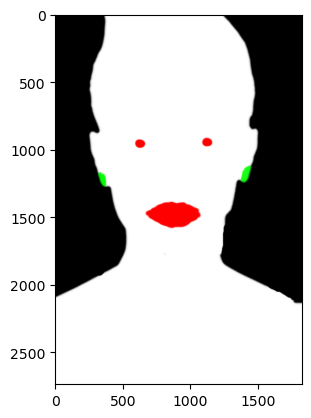

In [7]:
image = Image.open("./scan_mesh_working/mask_eye_lip_ear.png")
im_target = torch.tensor(image.getdata()).reshape(image.size[1],image.size[0],4)
im_target = im_target.float()[:,:,:3].cuda()
print(image.size[0],image.size[1],im_target.shape,torch.max(im_target[:]/255))
"""
im_target = im_target.unsqueeze(0).unsqueeze(0) 
b = torchvision.transforms.Resize([height,width])

im_target = b.forward(im_target)
im_target = im_target[0,0]
"""
im_target= im_target.cuda()
plt.imshow(im_target.cpu()/255)
print(image.size[0],image.size[1],im_target.shape,torch.max(im_target[:]/255))
print(im_target.dtype)


In [8]:
def raster(mesh,cam):
    vertices_camera = cam.extrinsics.transform(mesh.vertices)
    #print("vertices_camera",vertices_camera.requires_grad)
    face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(
        vertices_camera, mesh.faces)
    face_normals_z = kal.ops.mesh.face_normals(
        face_vertices_camera,
        unit=True
    )[..., -1:].contiguous()
    #print("Others",vertices_camera.grad,face_vertices_camera.grad,face_normals_z.grad)
    # Create a fake W (See nvdiffrast documentation)
    proj = cam.projection_matrix()
    homogeneous_vecs = kal.render.camera.up_to_homogeneous(
        vertices_camera
    )[..., None]

    vertices_clip = (proj @ homogeneous_vecs).squeeze(-1)

     #kaolin.render.mesh.dibr_rasterization(height, width, face_vertices_z, face_vertices_image, face_features, face_normals_z, sigmainv=7000, boxlen=0.02, knum=30, multiplier=None, eps=None, rast_backend='cuda')¶
    
    rast = nvdiffrast.torch.rasterize(
        nvctx, vertices_clip, mesh.faces.int(),
        (cam.height, cam.width), grad_db=True
    )
    return rast, vertices_clip

In [19]:
def render(mesh, cam, rays_d):
    rast,vertices_clip = raster(mesh,cam)
    rast0 = torch.flip(rast[0], dims=(1,)).contiguous()
    uv_map = nvdiffrast.torch.interpolate(
        mesh.uvs, rast0, mesh.face_uvs_idx.int()
    )[0] % 1.

    normals = nvdiffrast.torch.interpolate(
        mesh.vertex_normals, rast0, mesh.face_uvs_idx.int()
    )[0]
    with torch.no_grad():
        hard_mask = rast0[:, :, :, -1:] != 0
        normals[:] = normals/(torch.sqrt(torch.sum(normals*normals,dim = -1, keepdim = True)+0.001))
    # Obj meshes can be composed of multiple materials
    # so at rendering we need to interpolate from corresponding materials
    \

    pixel_val = nvdiffrast.torch.texture(
                materials.contiguous(),
                uv_map.contiguous(),
                filter_mode='linear'
                )
    
    
    pic = torch.clamp(pixel_val*hard_mask, 0., 1.)
    res = pic
    with torch.no_grad():
        res[:] = nvdiffrast.torch.antialias(res,rast[0],vertices_clip, mesh.faces.int(),pos_gradient_boost=100.0)
    
    return res[0]
    diffuse = kal.render.lighting.sg_diffuse_fitted(amplitude, source, sharpness, normals[hard_mask[:,:,:,0],:], res[hard_mask[:,:,:,0],:])
    res *= 0.1
    res[hard_mask[:,:,:,0],:] += 0.6*diffuse

    
    specular_effect = kal.render.lighting.sg_warp_specular_term(
            amplitude,
            source,
            sharpness,
            normals[hard_mask[:,:,:,0],:],
            roughness[hard_mask.squeeze(-1)],
            rays_d[hard_mask[:,:,:,0],:],
            spec_albedo[hard_mask[:,:,:,0],:]
        )
    #print(specular_effect.max())
    res[hard_mask[:,:,:,0],:] += 0.3*specular_effect

    
    #ref = 2*torch.inner(normals,-direction)*normals+direction
    #spec = torch.sum(rays_d*ref,dim=-1).unsqueeze(-1)*spec_albedo
    #res[hard_mask[:,:,:,0],:] += 0.5*spec[hard_mask[:,:,:,0],:] 
    return (res)[0]
    
   

In [10]:
def shadow_mask(mesh,light):
    rast, vert = raster(mesh,light)
    t_id = rast[0][:,:,:,3]
    
    return t_id[:]

In [11]:
print(torch.max(shadow_mask(mesh,light)[:]))

tensor(0., device='cuda:0')


In [12]:
def render1(mesh, cam):
    vertices_camera = cam.extrinsics.transform(mesh.vertices)
    #print("vertices_camera",vertices_camera.requires_grad)
    face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(
        vertices_camera, mesh.faces)
    
    face_normals_z = kal.ops.mesh.face_normals(
        face_vertices_camera,
        unit=True
    )[..., -1].contiguous()
    #print("Others",vertices_camera.grad,face_vertices_camera.grad,face_normals_z.grad)
    # Create a fake W (See nvdiffrast documentation)
    vertices_ndc = cam.intrinsics.transform(vertices_camera)
    face_vertices_image = kal.ops.mesh.index_vertices_by_faces(vertices_ndc[..., :2], mesh.faces)

    face_attributes = [
        mesh.face_uvs.repeat(1, 1, 1, 1),
        torch.ones((1, mesh.faces.shape[0], 3, 1), device='cuda')
    ]
    #print(face_vertices_camera[...,2].shape, face_vertices_image[...,:2].shape,face_normals_z[...,0].shape)
    image_features, soft_mask, face_idx =kal.render.mesh.dibr_rasterization(
        height, width, face_vertices_camera[...,2], face_vertices_image, face_attributes,face_normals_z, 
        sigmainv=7000, boxlen=0.02, knum=30, multiplier=None, eps=None, rast_backend='nvdiffrast')
    return soft_mask[0]
    

In [13]:


#camera = kal.render.easy_render.default_camera(512).cuda()
#lighting = kal.render.easy_render.default_lighting().cuda()
lighting = kal.render.lighting.SgLightingParameters(amplitude=3.0, direction=pos, sharpness=5.0).cuda()

ext_params, int_params = camera.parameters()
ext_mask, int_mask = camera.gradient_mask("t",'focal_x','focal_y')
grad_scale = 1e3
gradscale_2 = 1e-6
ext_params.register_hook(lambda grad: grad *ext_mask.int()*gradscale_2)
    # Used to move the projection matrix elements faster
int_params.register_hook(lambda grad: grad *int_mask.int()*grad_scale)


optim = torch.optim.SGD(camera.parameters(), lr=2., momentum = 0.)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min',patience=200,factor=0.5,min_lr = 1.)



In [14]:
print(ray_d.min(), ray_d.max())

tensor(-0.0667, device='cuda:0') tensor(1., device='cuda:0')


/home/bhartrhari/miniconda3/envs/kaolin_nv/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


torch.Size([2736, 1824, 3]) (2736, 1824, 3) [0.01195884 0.01195884 0.01195884 ... 0.46315193 0.46315193 0.46315193] 1.0


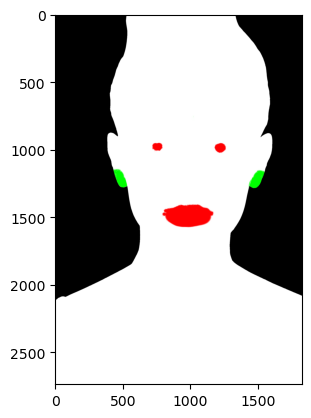

In [15]:
plt.figure()
with torch.no_grad():
    t = torch.clamp(render(mesh,camera,ray_d),0.,1.).cpu().detach().numpy()
    a = t[t>0]
    b = a[a<1]
    print(im_target.shape,t.shape,b,np.max(t[:]))
    plt.imshow(t)
p = Image.fromarray(np.uint8(t*255))
p.save("test_img.png")

In [16]:
a = torch.ones([3,4,1])
b = torch.transpose(torch.transpose(torch.ones([3,4,1])*2,0,1),1,2)
print(torch.tensordot(a,b,dims=2).shape)
print(torch.tensordot(a,b,dims=2))

torch.Size([3, 3])
tensor([[8., 8., 8.],
        [8., 8., 8.],
        [8., 8., 8.]])


In [17]:
def disp_imgs(img1,img2,img3,title=None):
    """scatter images plotting"""
    
    f, axes = plt.subplots(2, 2, figsize=(4 * 2, 4. * 2))
    f.suptitle(title, fontsize=16)
    plt.subplots_adjust(wspace=0, hspace=0.3)
    
    axes[0, 0].imshow(img1.cpu().detach())
    axes[0, 0].set_xticks([])
    axes[0, 0].set_title("Trained")

    axes[1, 0].imshow(img2.cpu().detach())
    axes[1, 0].set_xticks([])
    axes[1, 0].set_title("Target")

    axes[0, 1].imshow(t)
    axes[0, 1].set_xticks([])
    axes[0, 1].set_title("Initial guess")
    
    axes[1, 1].imshow(img3.cpu().detach())
    axes[1, 1].set_xticks([])
    axes[1, 1].set_title("Difference between Trained and Target")

loss_plt = []
iter_arr = []       

CameraExtrinsics of 1 cameras, of coordinate system: 
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0'). 
Camera #0 View Matrix: 
tensor([[[ 1.0000, -0.0000,  0.0000,  0.0100],
         [ 0.0000,  0.9964, -0.0847,  0.0299],
         [ 0.0000,  0.0847,  0.9964, -2.0047],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CatBackward0>),
Camera #0 Inverse View Matrix: 
tensor([[[ 1.0000,  0.0000,  0.0000, -0.0100],
         [-0.0000,  0.9964,  0.0847,  0.1400],
         [ 0.0000, -0.0847,  0.9964,  2.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CopySlices>)

9.86791706085205
7.350910663604736
4.488821506500244
2.7192838191986084
2.487236738204956
2.383854389190674
2.2956278324127197
2.207872152328491
2.132641315460205
2.077129364013672
2.024946451187134
1.9832991361618042
1.9492391347885132
1.916868805885315
1.882917046546936
1.8562833070755005
1.8290214538574219
1.807785034179687

<Figure size 640x480 with 0 Axes>

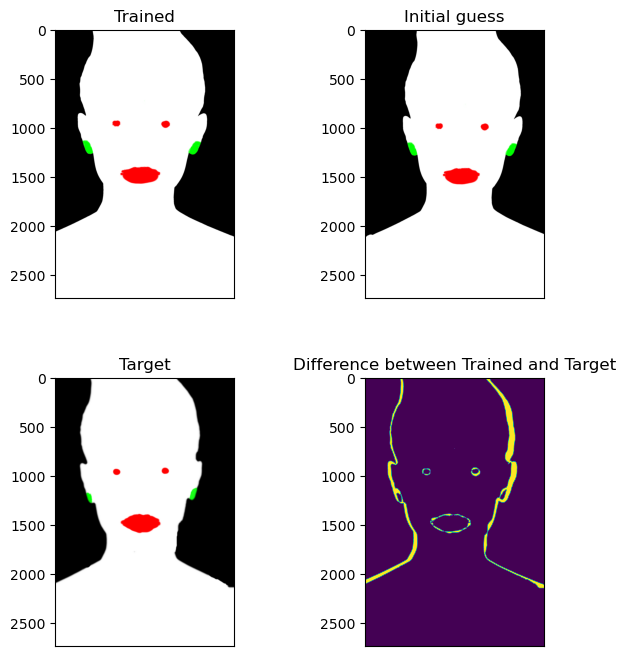

In [20]:

plt.figure()
print(camera.extrinsics)

for i in range(4000):
    optim.zero_grad()
    with torch.no_grad():
        #camera.cam_pos[2]=1.0
        #camera.position[0] = 0.
        #optim.lr = 1*(1000-t)
        #optim.momentum = 0.09*(1000-t)
        pass
    rendered = render(mesh,camera,ray_d)
    #print(rendered.shape)
    #rendered = torch.mean(rendered,dim=2)
    
    #print(rendered.shape,im_target.shape)
    
    pos1,pos2,pos3 = camera.extrinsics.view_matrix()[0,:3,-1]
    
    
    p = im_target.float()/255
    
    
    loss = 100*torch.nn.functional.mse_loss(rendered,p)#+5*torch.abs(camera.focal_x-camera.focal_y)/camera.focal_x#+10*(pos1*pos1)
    loss.backward()
    
    #del loss
    #del rendered
    #print("Rendered",rendered.grad)
    #print(torch.max(rendered.grad[:]))
    #
    optim.step()
    torch.cuda.empty_cache()
    #scheduler.step(loss)
    
    #render(mesh,camera)
    #print(f'Intrinsics: {camera.parameters()}')
    if i%10==0:
        loss_plt.append(loss)
        if len(iter_arr)>0:

            iter_arr.append(iter_arr[-1]+10)
        else:
            iter_arr.append(i)
    if i%100==0:
        print(loss.item())
        
        #print(pos1.item(),pos2.item(),pos3.item())
        #print("FOV",camera.fov().item())
        #print(f'Gradient: {camera.parameters()[1]}: Loss: {loss}')
        #print(rendered.grad)
        
    

p = torch.zeros(rendered.shape[:-1]).unsqueeze(-1).cuda()
diff = torch.sum(torch.abs(rendered-im_target/255),dim=-1)/3
#print(max(diff))

p[diff>0.1]=1
#p[(rendered-im_target/255)<-0.1]=0.5
disp_imgs(rendered,im_target/255,p)


In [20]:
print(torch.max(diff))

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


In [21]:
torch.cuda.empty_cache()
p = torch.zeros(rendered.shape).cuda()
p[rendered-im_target/255>0]=1
print(camera.extrinsics)


CameraExtrinsics of 1 cameras, of coordinate system: 
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0'). 
Camera #0 View Matrix: 
tensor([[[ 1.0000,  0.0000,  0.0000, -0.0048],
         [ 0.0000,  0.9964, -0.0847,  0.0316],
         [-0.0000,  0.0847,  0.9964, -2.0021],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CatBackward0>),
Camera #0 Inverse View Matrix: 
tensor([[[ 1.0000,  0.0000, -0.0000,  0.0048],
         [ 0.0000,  0.9964,  0.0847,  0.1381],
         [ 0.0000, -0.0847,  0.9964,  1.9976],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CopySlices>)



[9.867911338806152, 9.60588264465332, 9.351273536682129, 9.094200134277344, 8.830636978149414, 8.58142375946045, 8.340718269348145, 8.08946418762207, 7.848002910614014, 7.589200019836426, 7.322969913482666, 7.047337532043457, 6.7686944007873535, 6.496685981750488, 6.2213921546936035, 5.934173107147217, 5.6548991203308105, 5.364521026611328, 5.072770595550537, 4.767336845397949, 4.4613189697265625, 4.1714558601379395, 3.910839557647705, 3.672532796859741, 3.4675095081329346, 3.273780584335327, 3.110764503479004, 2.9727699756622314, 2.861795663833618, 2.777738571166992, 2.7086405754089355, 2.659531831741333, 2.618520736694336, 2.580528974533081, 2.554473638534546, 2.535034418106079, 2.523686170578003, 2.5099987983703613, 2.501124858856201, 2.4950966835021973, 2.4843246936798096, 2.472719669342041, 2.462453842163086, 2.4558238983154297, 2.44893741607666, 2.4375224113464355, 2.4191408157348633, 2.4114816188812256, 2.4014413356781006, 2.39188289642334, 2.3822200298309326, 2.3736419677734375

Text(0.5, 1.0, 'Diverging plot for a good guess')

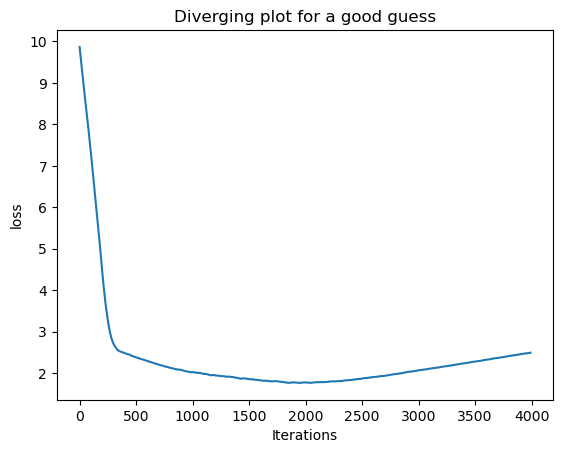

In [19]:
loss_plt2 = [i.detach().cpu().item() for i in loss_plt]
print(loss_plt2)
plt.plot(iter_arr,loss_plt2)
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.title("Diverging plot for a good guess")


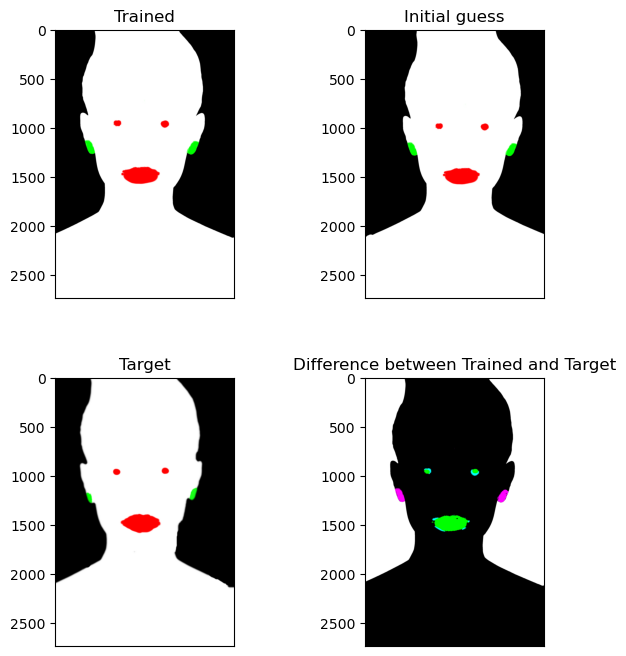

In [36]:
disp_imgs(rendered,im_target.cuda()/255,(1-rendered)*(1-p))

In [37]:
optim.lr = 10
optim.momentum = 0.009
print(torch.min(im_target[:]))

tensor(0., device='cuda:0')


In [38]:
with torch.no_grad():
    t = render(mesh,camera).cpu().detach().numpy()
    print(im_target.dtype)
    plt.imshow(t[:,:,1])

TypeError: render() missing 1 required positional argument: 'rays_d'

In [39]:
torch.cuda.empty_cache()

In [40]:
torch.save(camera.view_matrix().detach(),"./saved_cam_trans.pt")
torch.save(camera.parameters()[1].detach(),"./saved_cam_int.pt")
torch.save((height,width),"./saved_cam_hw.pt")


In [26]:
print(camera.projection_matrix())

tensor([[[15.3759,  0.0000,  0.0000,  0.0000],
         [ 0.0000, 10.2523,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.0002, -0.0200],
         [ 0.0000,  0.0000, -1.0000,  0.0000]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>)


In [31]:
p = torch.load("./saved_cam_trans.pt",weights_only=False)
intr = torch.load("./saved_cam_int.pt",weights_only=False)


In [32]:
print(p,intr)
cam2 = kal.render.camera.Camera.from_args(view_matrix = p, focal_x =intr[0,2],focal_y=intr[0,3],width = width, height=height)

tensor([[[ 9.9998e-01, -7.1253e-04, -6.1022e-03, -1.1819e-02],
         [ 6.7841e-04,  9.9998e-01, -5.5909e-03,  1.0095e-02],
         [ 6.1061e-03,  5.5866e-03,  9.9997e-01, -2.0018e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0') tensor([[   0.0000,    0.0000, 6518.4834, 6518.4678]], device='cuda:0')


In [33]:
plt.figure()
with torch.no_grad():
    t = render(mesh,cam2).cpu().detach().numpy()
    a = t[t>0]
    b = a[a<1]
    print(im_target.shape,t.shape,b,np.max(t[:]))
    plt.imshow(t)

TypeError: render() missing 1 required positional argument: 'rays_d'

<Figure size 640x480 with 0 Axes>

In [ ]:
"""
    proj_mat = kal.render.camera.generate_perspective_projection(cam.fov())
    transform = kal.render.camera.generate_transformation_matrix(cam.position,cam.at,cam.up)

    face_vertices_camera, face_vertices_image, face_normals = \
        kal.render.mesh.prepare_vertices(
            vertices_batch.repeat(in_batch_size, 1, 1),
            mesh.faces, proj_mat, camera_transform=transform)
    return True
    
    
    vertices_camera = cam.extrinsics.transform(mesh.vertices)
    #print("vertices_camera",vertices_camera.requires_grad)
    face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(
        vertices_camera, mesh.faces)
    face_normals_z = kal.ops.mesh.face_normals(
        face_vertices_camera,
        unit=True
    )[..., -1:].contiguous()
    #print("Others",vertices_camera.grad,face_vertices_camera.grad,face_normals_z.grad)
    # Create a fake W (See nvdiffrast documentation)
    proj = cam.projection_matrix()
    homogeneous_vecs = kal.render.camera.up_to_homogeneous(
        vertices_camera
    )[..., None]

    vertices_clip = (proj @ homogeneous_vecs).squeeze(-1)

     #kaolin.render.mesh.dibr_rasterization(height, width, face_vertices_z, face_vertices_image, face_features, face_normals_z, sigmainv=7000, boxlen=0.02, knum=30, multiplier=None, eps=None, rast_backend='cuda')¶
    
    rast = nvdiffrast.torch.rasterize(
        nvctx, vertices_clip, mesh.faces.int(),
        (cam.height, cam.width), grad_db=True
    )
    rast0 = torch.flip(rast[0], dims=(1,)).contiguous()
    """